In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
import random

#save and load dictionaries/lists
import pickle

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance, is_day, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_pen_tr = config.dico_pen_tr
li_binmn = config.li_binmn
penalty = config.penalty
dico_window = config.dico_window
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
max_date_adaptability = config.max_date_adaptability
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [4]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(227, 14)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,pen9,EPI,1.0,2020-06-10,NaN,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,pen11,LEXP,1.0,2020-06-10,NaN,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,pen5,EPI,3.0,2020-06-10,NaN,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [5]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
df_daily = df_daily[['HenID','PenID','level','Treatment', 'CLASS', 'DOA','WOA', 'perc_duration_2_Zone',
                     'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone','Total_number_transition']]
#display(df_daily[df_daily.isna().any(axis=1)])
if df_daily[df_daily.isna().any(axis=1)].shape[0]>0:
    print('ERROR')
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42752, 12)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_transition
0,hen_130,pen10,2020-10-05,TRAN,EPI,124,18,0.0,0.0,0.0,100.0,0.0
1,hen_130,pen10,2020-10-06,TRAN,EPI,125,18,0.0,2.0,1.0,97.0,3.0
2,hen_130,pen10,2020-10-07,TRAN,EPI,126,18,1.0,1.0,0.0,98.0,4.0


In [6]:
min(df_daily['DOA'].tolist()), max(df_daily['DOA'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(119, 417)

In [7]:
min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(17, 60)

In [8]:
mi = min(df_daily['DOA'].tolist())
ma = max(df_daily['DOA'].tolist())
print('We are involving a period of %d days of tracking during the days from the DOA %d until DOA %d'%(ma-mi, mi, ma))

We are involving a period of 298 days of tracking during the days from the DOA 119 until DOA 417


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# choose subset of hens

In [9]:
df_daily['CLASS'].value_counts(normalize=True)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NewAfterEpi        0.274397
MEXP               0.233626
EPI                0.223101
LEXP               0.189091
LEXPLOST           0.060816
MEXPLOST           0.015508
NewAfterEpiLOST    0.003462
Name: CLASS, dtype: float64

In [10]:
df_daily = df_daily[df_daily['CLASS']=='EPI']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visual

In [11]:
#heatmap of the hens, one row per hen: 1 means existing tracked day for the hen
df_plt = df_daily[['HenID', 'PenID', 'Treatment', 'CLASS','level','perc_duration_5_Zone']].copy()
dico_cl = {'EPI':'unknown', 'LEXP':'LEXP', 'MEXP':'MEXP', 'LEXPLOST':'unknown', 'MEXPLOST':'unknown'}
df_plt['CLASS'] = df_plt['CLASS'].map(lambda x: dico_cl[x])

##### find missing days
Daterange = pd.date_range(start = dt.datetime(2020,9,30), end = max_date_adaptability, freq = 'D')    
li_missing_dates = [i for i in Daterange if i not in df_plt['level'].unique()]

##### add one row per missing dates for a random hen with perc_duration_5_Zone beeing np.nan
x = df_plt.iloc[0]
df_missingdate = pd.DataFrame([{'level':d, 'perc_duration_5_Zone':np.nan, 'HenID':x['HenID'], 'PenID':x['PenID'], 
                                'Treatment':x['Treatment'],'CLASS':x['CLASS']} for d in li_missing_dates])
print(df_plt.shape)
df_plt = df_plt.append(df_missingdate, ignore_index=True)
print(df_plt.shape)
df_plt['level'] = df_plt['level'].map(lambda x: dt.datetime.date(x))
df_plt.sort_values(['level'], inplace=True)
li_date = df_plt['level'].unique()

##### say if bird was tracked on taht day or not (i.e. we have his duration in zone 5)
df_plt['Tracked'] = df_plt['perc_duration_5_Zone'].map(lambda x: int(not math.isnan(x)))
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['HenID', 'PenID', 'Treatment', 'CLASS'], columns='level', values='Tracked').reset_index()
df_plt = df_plt.fillna(0)
df_plt.sort_values(['PenID'], inplace=True)
li_henorder = df_plt['HenID'].tolist()
print(df_plt.shape)
df_plt.head(3)

(9538, 6)
(9540, 6)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,Treatment,CLASS,level,perc_duration_5_Zone,Tracked
500,hen_161,pen10,TRAN,unknown,2020-09-30,76.0,1
6160,hen_32,pen5,OFH,unknown,2020-09-30,0.0,1
2424,hen_91,pen11,OFH,unknown,2020-09-30,72.0,1


(77, 291)


level,HenID,PenID,Treatment,CLASS,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,...,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,2021-07-25
59,hen_59,pen10,TRAN,unknown,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
54,hen_49,pen10,TRAN,unknown,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,hen_131,pen10,TRAN,unknown,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#order the hens according to their number of availability
#df_plt = df_plt.drop(['nbr_days_tot'], axis=1) #otherwise two runs multiply the true value by 2
df_plt['nbr_days_tot'] = df_plt.apply(lambda x: sum([x[i] for i in df_plt.columns if i not in ['level','HenID','PenID','Treatment','CLASS']]), axis=1)
df_plt = df_plt.sort_values(['nbr_days_tot'], ascending=False)
df_plt.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


level,HenID,PenID,Treatment,CLASS,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,...,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,2021-07-25,nbr_days_tot
59,hen_59,pen10,TRAN,unknown,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,278.0
34,hen_28,pen11,OFH,unknown,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,277.0
30,hen_18,pen9,OFH,unknown,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,276.0


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


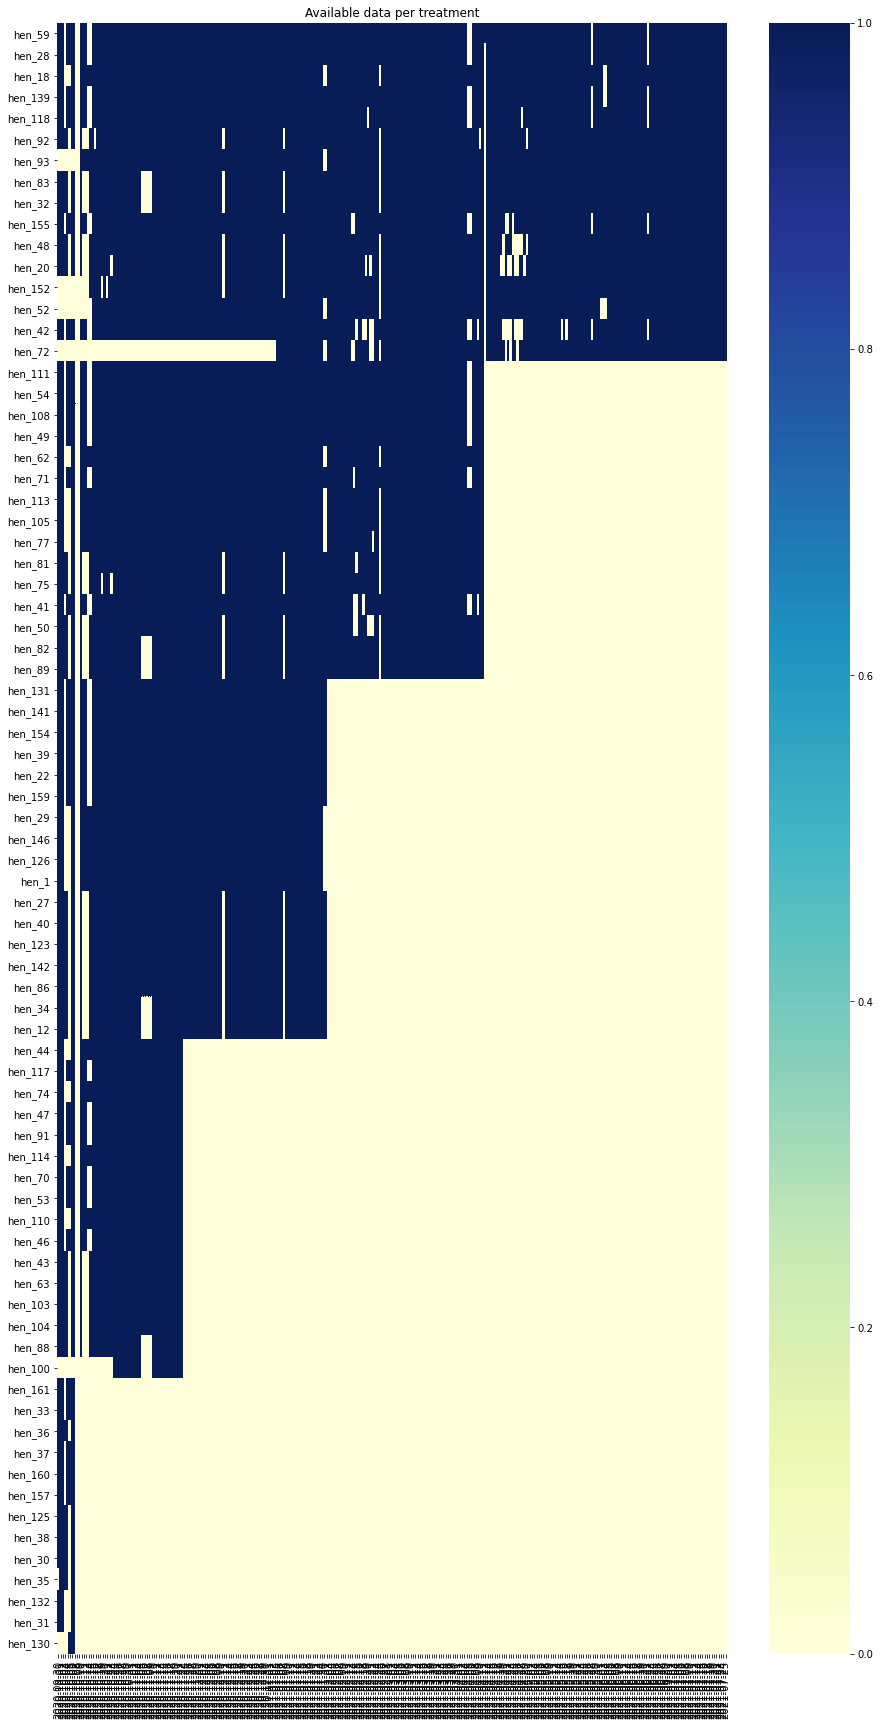

In [13]:
#per hens
fig = plt.figure(figsize=(15,30))
sns.heatmap(df_plt[li_date].to_numpy(), xticklabels=li_date,  yticklabels=df_plt['HenID'].tolist(), cmap="YlGnBu")
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_visual,'DataPerHens_EPI.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


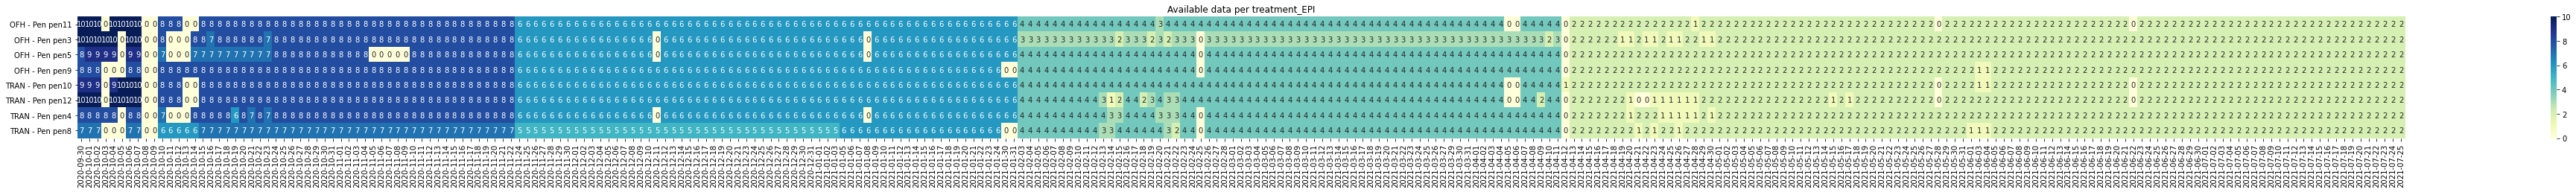

In [14]:
#per treatment
df_plt_summarized = df_plt.groupby(['Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['Treatment']+' - Pen '+str(x['PenID']), axis=1)
fig = plt.figure(figsize=(70,3))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per treatment_EPI')
plt.savefig(os.path.join(path_extracted_data_visual,'DataPerTreatment_EPI.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()